In [41]:
import tensorflow as tf
import numpy as np
import random
import cv2
import os
import time
import matplotlib.pyplot as plt

%matplotlib inline

from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, metrics
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications.inception_v3 import preprocess_input


In [22]:
def create_triplets(directory, img_per_class=None):
    triplets = []
    folders = os.listdir(directory)
    try:
        folders.remove(".DS_Store")
    except ValueError:
        pass
    for folder in folders[:50]:

        path = os.path.join(directory, folder)
        files = os.listdir(path)
        try:
            files.remove(".DS_Store")
        except ValueError:
            pass
        

        # Creating training triplets
        for anchor_file in files[:img_per_class]:
            positive_file = random.choice([file for file in files if file != anchor_file])
            negative_folder = random.choice([f for f in folders[:10] if f != folder])
            negative_images = os.listdir(os.path.join(directory, negative_folder))
            try:
                negative_images.remove(".DS_Store")
            except ValueError:
                pass
            negative_file = random.choice(negative_images)
            triplets.append(((folder, anchor_file), (folder, positive_file), (negative_folder, negative_file)))

    random.shuffle(triplets)

    return triplets

In [14]:
# Setting random seeds to enable consistency while testing.
random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)
ROOT = 'dataset'
def read_image(path):
    image_1 = cv2.imread(path)
    image = cv2.resize(image_1, (128, 128))

    if image is not None:
        return image
    else:
        print(f"Error: Unable to load image at path {path}")
        return None

In [2]:
def get_encoder(input_shape):
    """ Returns the image encoding model """

    pretrained_model = Xception(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg',
    )
    print(len(pretrained_model.layers))

    for i in range(len(pretrained_model.layers)-27):
        pretrained_model.layers[i].trainable = False

    encode_model = Sequential([
        pretrained_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
        layers.Dropout(0.5),

        layers.BatchNormalization(),
        layers.Dense(256, activation="relu", kernel_regularizer=l2(0.001)),
        layers.Dropout(0.5),

        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="Encode_Model")

    print(len(encode_model.layers))
    return encode_model

In [3]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


def get_siamese_network(input_shape = (128, 128, 3)):
    encoder = get_encoder(input_shape)

    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")

    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)

    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoder(anchor_input),
        encoder(positive_input),
        encoder(negative_input)
    )

    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network



In [4]:

class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()

        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

In [5]:
def extract_encoder(model):
    encoder = get_encoder((128, 128, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder


In [17]:
def get_custom_batch(triplet_list, data_type, batch_size=4, preprocess=True):
    batch_steps = len(triplet_list)//batch_size

    for i in range(batch_steps+1):
        anchor   = []
        positive = []
        negative = []

        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            # print(a,p,n)
            anchor.append(read_image(f'faces_ds/{data_type}/{a[0]}/{a[1]}'))
            positive.append(read_image(f'faces_ds/{data_type}/{p[0]}/{p[1]}'))
            negative.append(read_image(f'faces_ds/{data_type}/{n[0]}/{n[1]}'))
            j+=1

        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)

        if preprocess:
            anchor = preprocess_input(anchor)
            positive = preprocess_input(positive)
            negative = preprocess_input(negative)

        yield ([anchor, positive, negative])

In [19]:
def test_on_triplets(batch_size = 4):
    pos_scores, neg_scores = [], []

    for data in get_custom_batch(validation_triplet, 'validation',batch_size=batch_size):
        prediction = siamese_model.predict(data)
        # print(prediction)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])

    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)

    print(f"Accuracy on validation = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

In [23]:
# Example usage
train_triplet = create_triplets("faces_ds/train")
validation_triplet = create_triplets("faces_ds/validation")
# validation_triplet = create_triplets("dataset/validation", 10)
# train_triplet.extend(validation_triplet)

print(len(train_triplet))
print(len(validation_triplet))

446
193


In [37]:
siamese_network = get_siamese_network()
siamese_network.summary()

133
8
Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Anchor_Input (InputLayer)      [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Positive_Input (InputLayer)    [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Negative_Input (InputLayer)    [(None, 128, 128, 3  0           []                               
                                )]                                            

In [38]:
siamese_model = SiameseModel(siamese_network)

optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.001)

siamese_model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# Path to the saved weights
weights_path = "siamese_model"

# Load the previously saved weights
siamese_model.load_weights(weights_path)

print("Weights loaded successfully.")


best_acc_encoder = extract_encoder(siamese_model)
best_acc_encoder.save_weights("best_acc_encoder")
best_acc_encoder.summary()

Weights loaded successfully.
133
8
Model: "Encode_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_9 (Flatten)         (None, 2048)              0         
                                                                 
 dense_18 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_18 (Dropout)        (None, 512)               0         
                                                                 
 batch_normalization_49 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_19 (Dense)            (None, 256)               131328    
                   

In [30]:
siamese_model = SiameseModel(siamese_network)

optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.001)

siamese_model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# Path to the saved weights
weights_path = "Recognition_siamese_model_final"

# Load the previously saved weights
siamese_model.load_weights(weights_path)

print("Weights loaded successfully.")


encoder = extract_encoder(siamese_model)
encoder.save_weights("encoder")
encoder.summary()


Weights loaded successfully.
133
8
Model: "Encode_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_6 (Flatten)         (None, 2048)              0         
                                                                 
 dense_12 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_12 (Dropout)        (None, 512)               0         
                                                                 
 batch_normalization_34 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_13 (Dense)            (None, 256)               131328    
                   

In [39]:
save_all = False
epochs = 10
batch_size = 8

max_acc = 0
train_loss = []
test_metrics = []

os.makedirs("second_training", exist_ok=True)

for epoch in range(1, epochs+1):
    print(epoch)
    t = time.time()

    # Training the model on train data
    epoch_loss = []
    i = 0
    for data in get_custom_batch(train_triplet, "train", batch_size=batch_size):
        loss = siamese_model.train_on_batch(data)
        epoch_loss.append(loss)
        print(f"itr: {i}")
        i += 1

    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    train_loss.append(epoch_loss)

    print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
    print(f"Loss on train    = {epoch_loss:.5f}")
    # Testing the model on test data
    metric = test_on_triplets(batch_size=batch_size)
    test_metrics.append(metric)
    accuracy = metric[0]

    # Saving the model weights
    if save_all or accuracy>=max_acc:
        siamese_model.save_weights(f"second_training/siamese_best_acc_model_custom_best_acc")
        max_acc = accuracy


1
itr: 0
itr: 1
itr: 2
itr: 3
itr: 4
itr: 5
itr: 6
itr: 7
itr: 8
itr: 9
itr: 10
itr: 11
itr: 12
itr: 13
itr: 14
itr: 15
itr: 16
itr: 17
itr: 18
itr: 19
itr: 20
itr: 21
itr: 22
itr: 23
itr: 24
itr: 25
itr: 26
itr: 27
itr: 28
itr: 29
itr: 30
itr: 31
itr: 32
itr: 33
itr: 34
itr: 35
itr: 36
itr: 37
itr: 38
itr: 39
itr: 40
itr: 41
itr: 42
itr: 43
itr: 44
itr: 45
itr: 46
itr: 47
itr: 48
itr: 49
itr: 50
itr: 51
itr: 52
itr: 53
itr: 54
itr: 55

EPOCH: 1 	 (Epoch done in 22 sec)
Loss on train    = 0.90367
1/1 [==============================] - 0s 49ms/step
Accuracy on validation = 0.67358
2
itr: 0
itr: 1
itr: 2
itr: 3
itr: 4
itr: 5
itr: 6
itr: 7
itr: 8
itr: 9
itr: 10
itr: 11
itr: 12
itr: 13
itr: 14
itr: 15
itr: 16
itr: 17
itr: 18
itr: 19
itr: 20
itr: 21
itr: 22
itr: 23
itr: 24
itr: 25
itr: 26
itr: 27
itr: 28
itr: 29
itr: 30
itr: 31
itr: 32
itr: 33
itr: 34
itr: 35
itr: 36
itr: 37
itr: 38
itr: 39
itr: 40
itr: 41
itr: 42
itr: 43
itr: 44
itr: 45
itr: 46
itr: 47
itr: 48
itr: 49
itr: 50
itr: 51
itr: 

In [40]:
siamese_model.save_weights(f"second_training/siamese_best_acc_model_custom_full")


In [42]:
def plot_metrics(loss, metrics):
    # Extracting individual metrics from metrics
    accuracy = metrics[:, 0]
    ap_mean  = metrics[:, 1]
    an_mean  = metrics[:, 2]
    ap_stds  = metrics[:, 3]
    an_stds  = metrics[:, 4]

    plt.figure(figsize=(15,5))

    # Plotting the loss over epochs
    plt.subplot(121)
    plt.plot(loss, 'b', label='Loss')
    plt.title('Training loss')
    plt.legend()

    # Plotting the accuracy over epochs
    plt.subplot(122)
    plt.plot(accuracy, 'r', label='Accuracy')
    plt.title('Testing Accuracy')
    plt.legend()

    plt.figure(figsize=(15,5))

    # Comparing the Means over epochs
    plt.subplot(121)
    plt.plot(ap_mean, 'b', label='AP Mean')
    plt.plot(an_mean, 'g', label='AN Mean')
    plt.title('Means Comparision')
    plt.legend()

    # Plotting the accuracy
    ap_75quartile = (ap_mean+ap_stds)
    an_75quartile = (an_mean-an_stds)
    plt.subplot(122)
    plt.plot(ap_75quartile, 'b', label='AP (Mean+SD)')
    plt.plot(an_75quartile, 'g', label='AN (Mean-SD)')
    plt.title('75th Quartile Comparision')
    plt.legend()

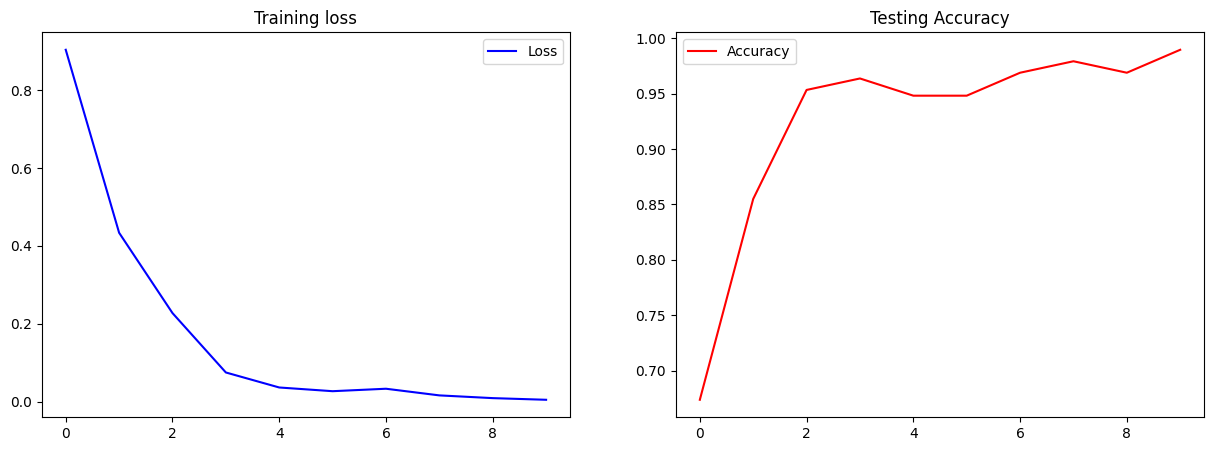

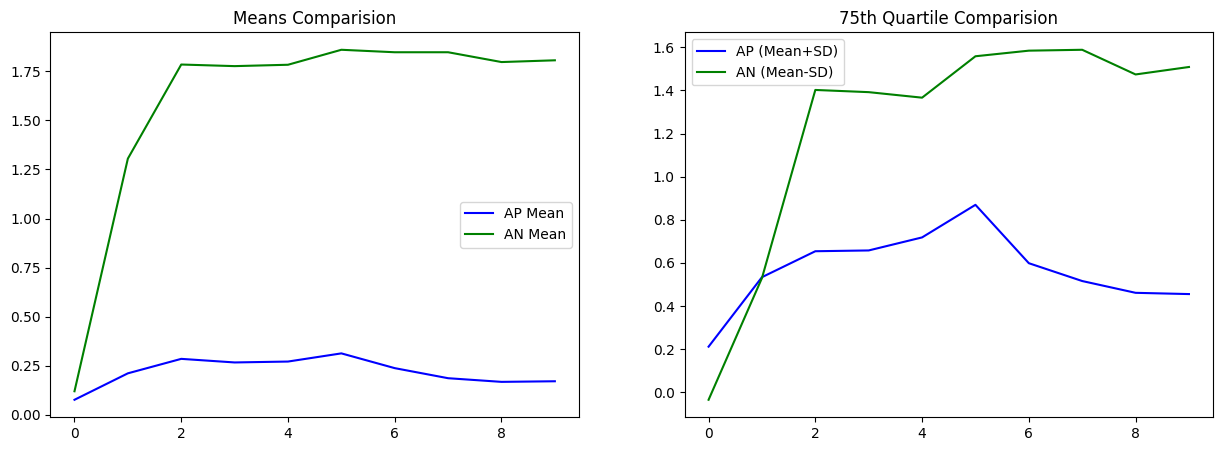

In [43]:
test_metrics = np.array(test_metrics)
plot_metrics(train_loss, test_metrics)